In [ ]:
import pandas as pd
import datetime as dt
import numpy as np

#Usamos el mismo dataset que venimos usando antes, con lo cual ya en este código acomodo todo lo que ya se hizo en otras entregas sólo para centrarnos en el análisis multivariado.
df = pd.read_csv('ar_properties.csv',encoding='latin1',sep=';',on_bad_lines='skip')
#Elimino la columna l6
df.drop('l6',axis=1,inplace=True)
#Me quedo sólo con las operaciones de Venta en dólares.
filtro = (df['operation_type'] == 'Venta') & (df['currency'] == 'USD')
df_filtrado = df.where(filtro)

#Redondeo los valores de rooms, bedrooms, bathrooms ya que son enteros y así agrupo mejor los valores
df_pre_multivariado = df_filtrado.round({'rooms':0,'bedrooms':0,'bathrooms':0})

#Redondeo los valores de Superficie Total y Superficie Cubierta ya que  así puedo comparar mejor gráficamente su relación.
df_multivariado = df_pre_multivariado.round({'surface_total':0,'surface_covered':0})

#Creo una nueva columna que sea el rango de precio para comprar rangos y no valores específicos.
criteria = [df_multivariado['price'].between(0,50000), df_multivariado['price'].between(50001,750000), df_multivariado['price'].between(75001,100000),df_multivariado['price'].between(100001,150000),df_multivariado['price'].between(150001,200000),df_multivariado['price'] > 200001]
values = ['0 - USD 50.000','USD 50.001 - USD 75.000','USD 75.001 - USD 100.000','USD 100.001 - USD 150.000','USD 150.001 - USD 200.000','USD > 250.000']

#Realizo el filtro y asigno la nueva columna
df_multivariado['price_range'] = np.select(criteria, values, 0)

#Elimino las propiedades sin tipificación cargada.
df_multivariado.dropna(subset=['property_type'],inplace=True)
df_multivariado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284055 entries, 0 to 393852
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       284055 non-null  object 
 1   end_date         284055 non-null  object 
 2   created_on       284055 non-null  object 
 3   lat              259389 non-null  object 
 4   lon              259389 non-null  object 
 5   l1               284055 non-null  object 
 6   l2               284055 non-null  object 
 7   l3               273053 non-null  object 
 8   l4               85786 non-null   object 
 9   l5               1491 non-null    object 
 10  rooms            204534 non-null  float64
 11  bedrooms         197502 non-null  float64
 12  bathrooms        212922 non-null  float64
 13  surface_total    113105 non-null  float64
 14  surface_covered  122102 non-null  float64
 15  price            284055 non-null  float64
 16  currency         284055 non-null  obje

In [ ]:
#Obtengo la cantidad según Tipo de Propiedad y Rango de Precio, para luego graficarlas 
temp_data = df_multivariado.groupby(['property_type','price_range'])[['price_range']].agg(['count'])
temp_data.columns = temp_data.columns.get_level_values(0)
radar_data = temp_data.unstack().reset_index()
radar_data

property_type    price_range                          \
price_range                  0 - USD 50.000 USD 50.001 - USD 75.000   
0                       Casa           2960                   60733   
1              Casa de campo             28                     556   
2                    Cochera           4369                     207   
3               Departamento          10775                  103551   
4                   Depósito             36                    1076   
5            Local comercial           1192                    4883   
6                       Lote          16720                   16689   
7                    Oficina            652                    3447   
8                       Otro            836                    4628   
9                         PH           1170                   13245   

                           
price_range USD > 250.000  
0                    4062  
1                      20  
2                      79  
3                    2464  
4                     281  
5                     758  
6                    2371  
7                     302  
8                    1278  
9                      21

In [ ]:
#Ahora preparo el DF para graficar
radar_data2=pd.DataFrame(radar_data["property_type"])

for i in radar_data["price_range"].columns:
    temp=radar_data["price_range"][i]
    radar_data2.insert(0,i,temp)

radar_data2.set_index("property_type",inplace=True)

import plotly.graph_objects as go

#seleccion de columns a chequear
columns = radar_data2.columns

#comienzo de lienzo en plotly
fig = go.Figure()

#primer grafico
for x in radar_data2.index:
    fig.add_trace(go.Scatterpolar(
          r=list(radar_data2.loc[x]),
          theta=columns,
          fill='toself',
          name=x
    ))

#output plot
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True,
  legend_title_text = "Propiedades",
  margin=dict(l=0, r=0, t=20, b=20),
  title={
        'text': "Rango de precio de Propiedades por Tipo.",
        'y':0.97,
        'x':0.0
         },
  legend=dict(
    yanchor="top",
    y=0.7,
    xanchor="right",
    x=0.15
)
)

fig.show()

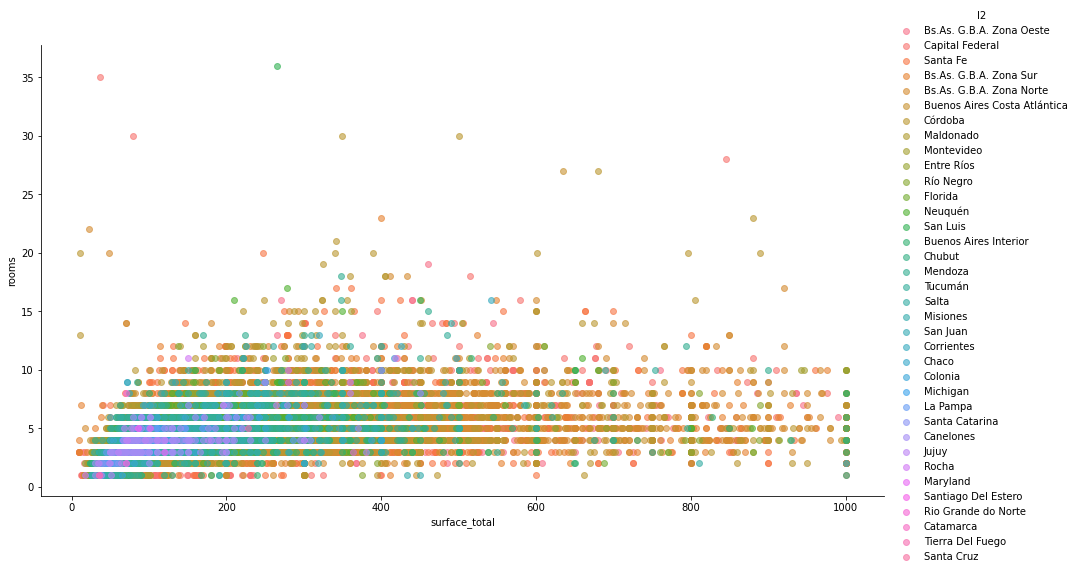

In [ ]:
#Ahora armo un scatterplot para analizar la relación entre la superficie total y los ambientes sólo para Casas y Departamentos que tengan como máximo 1000m2 en relación a su provincia.
import seaborn as sns
df_lmplot = df_multivariado.where(df['property_type'].isin(['Casa','Departamento']) & (df['surface_total']<=1000))
sns.lmplot(x='surface_total', y='rooms', data=df_lmplot, fit_reg=False,hue='l2',height=7, aspect=1.8,scatter_kws={'alpha': 0.6});

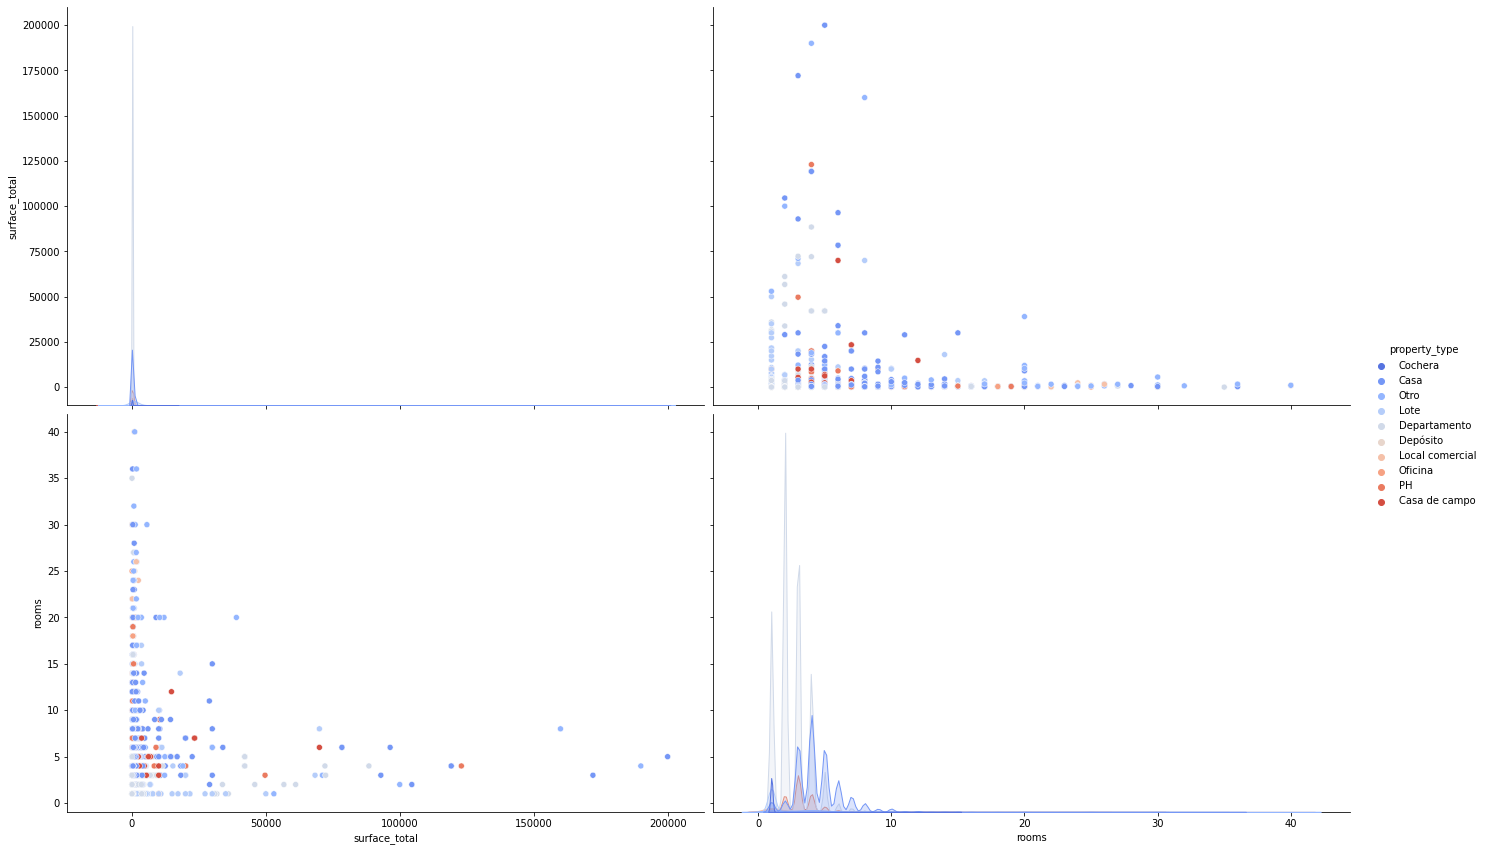

In [ ]:
df_pairplot = df_lmplot[['surface_total','rooms','property_type']]

sns.pairplot(df_pairplot,hue='property_type',palette='coolwarm',height=6, aspect=1.6);